In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np 

In [2]:
#This data is a time series of advance retail sales: NonRetail Sales
nonretail = pd.read_csv('C:/Users/rishp/Downloads/TSA/RSNSR.csv',parse_dates=["date"],index_col="date")
nonretail = nonretail.drop(["realtime_start","realtime_end"],axis=1)
nonretail.head()

,value
date,
1992-01-01,6515
1992-02-01,6110
1992-03-01,6018
1992-04-01,6327
1992-05-01,6550


In [3]:
nonretail.describe()

,value
count,334.000000
mean,25169.038922
std,15585.932812
min,6018.000000
25%,11615.000000
50%,22517.500000
75%,35163.750000
max,67912.000000


In [4]:
nonretail.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
nonretail.tail()

,value
date,
2019-06-01,65370
2019-07-01,66275
2019-08-01,67190
2019-09-01,67296
2019-10-01,67912


In [6]:
# We can see that data is present from January 1992 to October 2019. Also the value is in million dollars of retail sales

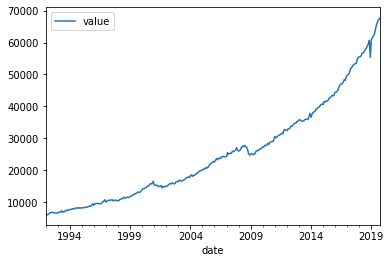

In [7]:
nonretail.plot()
plt.show()

In [8]:
#We have to check the stationarity of this dataset therefore we call the Augmented Dicky Fuller Test on the data
from statsmodels.tsa.stattools import adfuller

adf_stat = adfuller(nonretail['value'])
print(adf_stat)

(4.329975513852195, 1.0, 13, 320, {'1%': -3.450951662384033, '5%': -2.8706147570800784, '10%': -2.571604931640625}, 4828.036514196693)


First element of the tuple is the test statistic which is 4.329, therefore the data is not stationary

Second element of the tuple is p-value of the test-statistic which is 1.0 Since it is very high, we cannot reject the null hypothesis (non-stationary)

Fifth element is a dictionary. To get a p-value of 0.01 we need a test statistic of -3.45

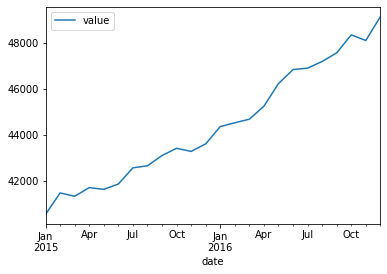

In [9]:
nonretail["2015":"2016"].plot()
plt.show()

In [10]:
# We have to make the data stationary therefore we have to use the percent change in order to get a stationary value

In [11]:
nonretail_yoy = nonretail.pct_change(12).dropna()
nonretail_yoy.head(5)

,value
date,
1993-01-01,0.019800
1993-02-01,0.109656
1993-03-01,0.164673
1993-04-01,0.085507
1993-05-01,0.115878


<AxesSubplot:xlabel='date'>

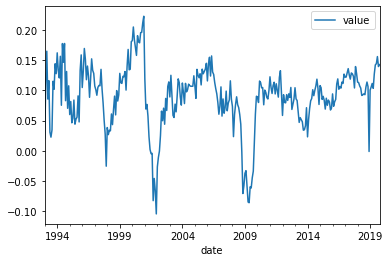

In [12]:
nonretail_yoy.plot()

In [13]:
print(adfuller(nonretail_yoy['value']))


(-3.539386161543893, 0.007031349115726733, 13, 308, {'1%': -3.45176116018037, '5%': -2.870970093607691, '10%': -2.571794416006072}, -1426.7503577647408)


In [14]:
#The p-value is down to 0.007 after transforming the data. Let's try differenencing on these values to check the p-value

<AxesSubplot:xlabel='date'>

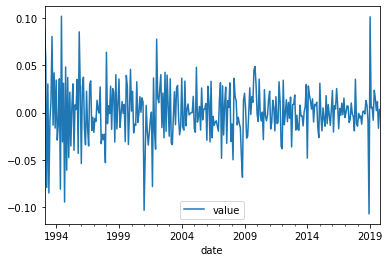

In [15]:
nonretail_yoy2 = nonretail_yoy.diff().dropna()
nonretail_yoy2.plot()

In [16]:
print(adfuller(nonretail_yoy2['value']))


(-7.43803590325631, 6.10942145129203e-11, 13, 307, {'1%': -3.4518314994261337, '5%': -2.8710009653519166, '10%': -2.571810878948318}, -1413.0989660847163)


In [17]:
#The p value here is close to 0. This data is now ready to build ARMA Models in order to model our data.

Simple ARMA and ARMAX Models

In [19]:
nonretail_yoy2 = nonretail_yoy2.asfreq("MS")

In [67]:
#Splitting into train and test
train = nonretail_yoy2.loc[:"2017"]
test = nonretail_yoy2.loc["2018":]
test.head()

,value
date,
2018-01-01,-0.014331
2018-02-01,-0.000801
2018-03-01,-0.005590
2018-04-01,-0.003451
2018-05-01,-0.012214


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model10 = SARIMAX(train,order=(1,0,1),trend="c")
results = model10.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  299
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 650.155
Date:                Sun, 10 Apr 2022   AIC                          -1292.311
Time:                        18:32:03   BIC                          -1277.509
Sample:                    02-01-1993   HQIC                         -1286.386
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.002      0.236      0.813      -0.003       0.003
ar.L1         -0.2395      0.174     -1.379      0.168      -0.580       0.101
ma.L1         -0.0477      0.178     -0.267      0.7

We can see that AR1, MA1 coefficient and the bias term or intercept is not at all significant


C:\Users\rishp\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


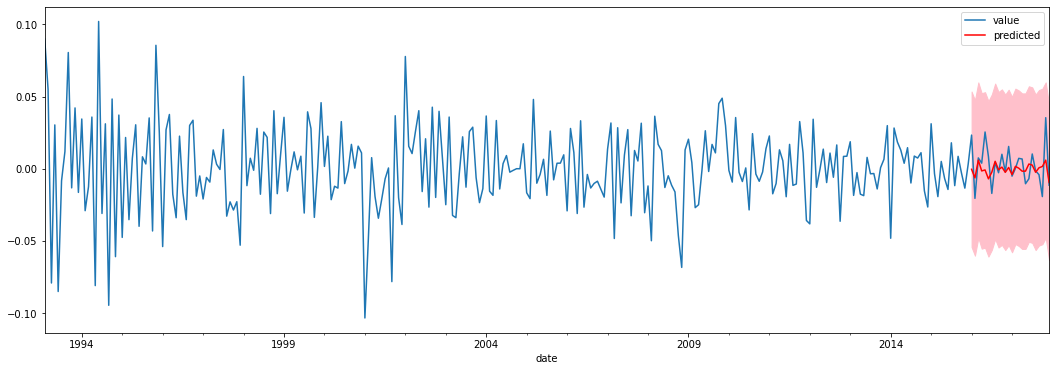

In [69]:
#One step ahead Forecasting
forecast = results.get_prediction(start=-24)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
fig,ax = plt.subplots(figsize=(18,6))
train.plot(ax=ax,label="observed")
mean_forecast.plot(ax=ax,color="r",label="predicted")
ax.fill_between(conf_int.index,conf_int["lower value"],conf_int["upper value"],color="pink")
ax.legend()
fig.show()

C:\Users\rishp\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


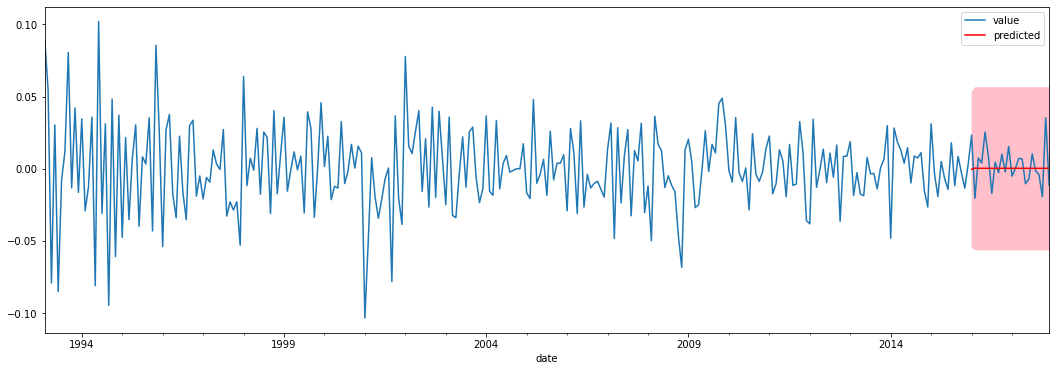

In [70]:
#Dynamic Forecasting in the past
forecast = results.get_prediction(start=-24,dynamic=True)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
fig,ax = plt.subplots(figsize=(18,6))
train.plot(ax=ax,label="observed")
mean_forecast.plot(ax=ax,color="r",label="predicted")
ax.fill_between(conf_int.index,conf_int["lower value"],conf_int["upper value"],color="pink")
ax.legend()
fig.show()

C:\Users\rishp\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


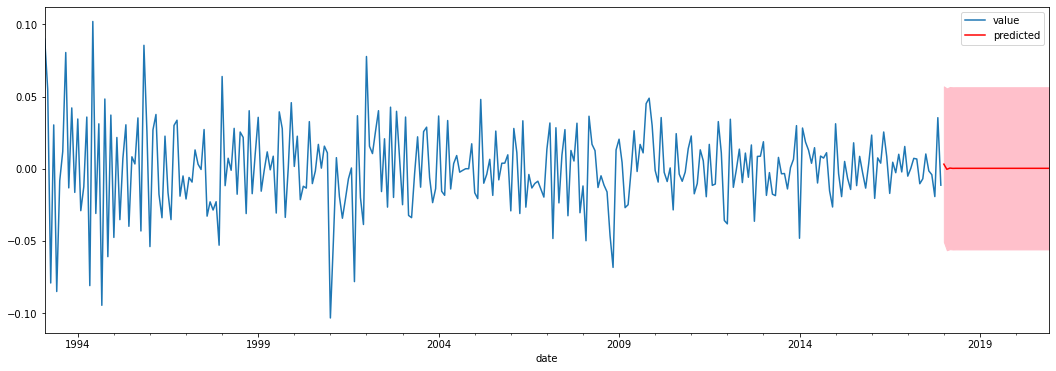

In [71]:
#Dynamic Forecasting into the future
forecast = results.get_forecast(steps=36)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
fig,ax = plt.subplots(figsize=(18,6))
train.plot(ax=ax,label="observed")
mean_forecast.plot(ax=ax,color="r",label="predicted")
ax.fill_between(conf_int.index,conf_int["lower value"],conf_int["upper value"],color="pink")
ax.legend()
fig.show()

In [72]:
#ARMAX model
trainx = train.copy()
trainx["month"] = trainx.index.month
trainx.head()

,value,month
date,,
1993-02-01,0.089856,2
1993-03-01,0.055016,3
1993-04-01,-0.079166,4
1993-05-01,0.030371,5
1993-06-01,-0.085065,6


In [73]:
modelx = SARIMAX(trainx["value"],order=(1,0,1),exog=trainx["month"])
resultsx = modelx.fit()
print(resultsx.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  299
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 650.177
Date:                Sun, 10 Apr 2022   AIC                          -1292.353
Time:                        18:32:19   BIC                          -1277.551
Sample:                    02-01-1993   HQIC                         -1286.429
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month       4.925e-05      0.000      0.289      0.773      -0.000       0.000
ar.L1         -0.2394      0.174     -1.377      0.168      -0.580       0.101
ma.L1         -0.0480      0.179     -0.269      0.7

Lets plot the ACF and the PACF

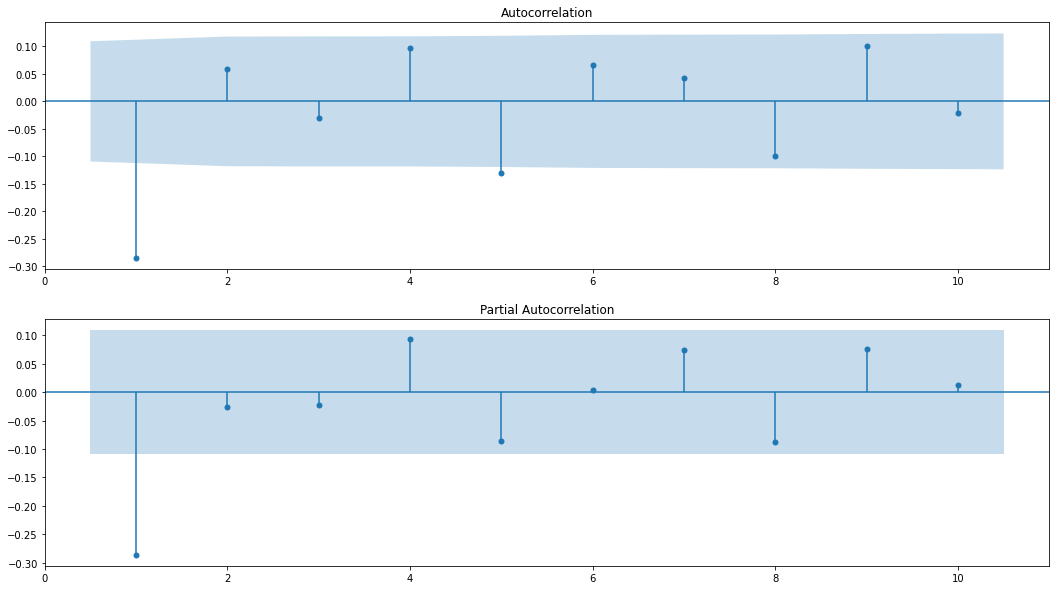

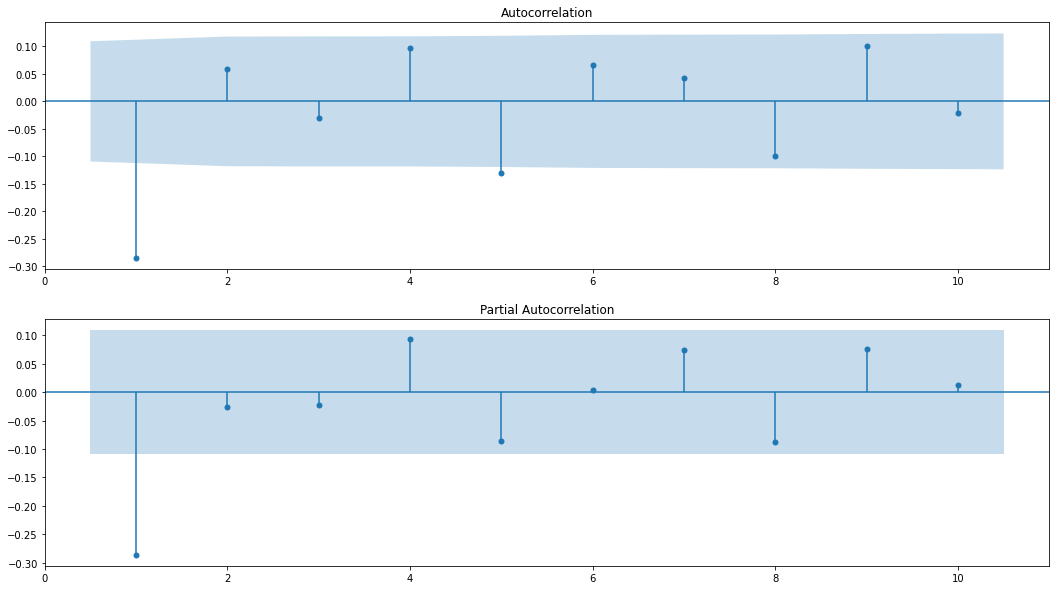

In [74]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, ax = plt.subplots(2,1,figsize=(18,10))
plot_acf(nonretail_yoy2,lags=10,zero=False,ax=ax[0])
plot_pacf(nonretail_yoy2,lags=10,zero=False,ax=ax[1])

In [88]:
aic_dict = {}
for p in range(0,3):
        for q in range(0,3):
            model = SARIMAX(train,order=(p,0,q),trend="c")
            res = model.fit(maxiter=500)
            print(p,q,res.aic,res.bic)

0 0 -1272.0483148500862 -1264.6474277033049
0 1 -1292.888288617188 -1281.786957897016
0 2 -1292.4663927029887 -1277.6646184094259
1 0 -1294.2570781105 -1283.155747390328
1 1 -1292.3105093390673 -1277.5087350455044
1 2 -1290.520874525098 -1272.0186566581444
2 0 -1292.3110630400297 -1277.5092887464668
2 1 -1290.2887664232985 -1271.786548556345
2 2 -1297.0747111721357 -1274.8720497317915


From the above AIC values, we can see that ARMA(2,2) ia the best fit

C:\Users\rishp\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


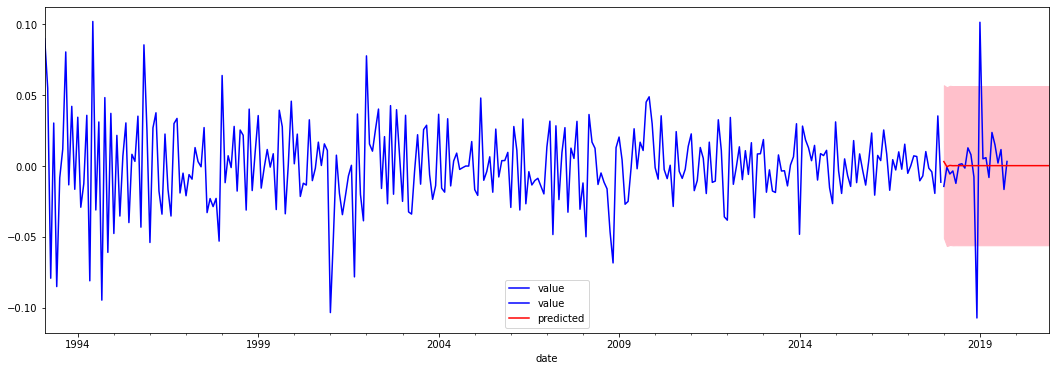

In [105]:
#ARMA(1,0) process

mod23 = SARIMAX(train,order=(2,0,2),trend="c")
res23 = mod23.fit(maxiter=500)

forecast = res23.get_forecast(steps=36)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
fig,ax = plt.subplots(figsize=(18,6))
train.plot(ax=ax,label="observed",color="blue")
test.plot(ax=ax,color="blue")
mean_forecast.plot(ax=ax,color="r",label="predicted")
ax.fill_between(conf_int.index,conf_int["lower value"],conf_int["upper value"],color="pink")
ax.legend()
fig.show()

In [92]:
print("Mean absolute error: {}".format(np.mean(np.abs(res23.resid))))

Mean absolute error: 0.020429398028841632


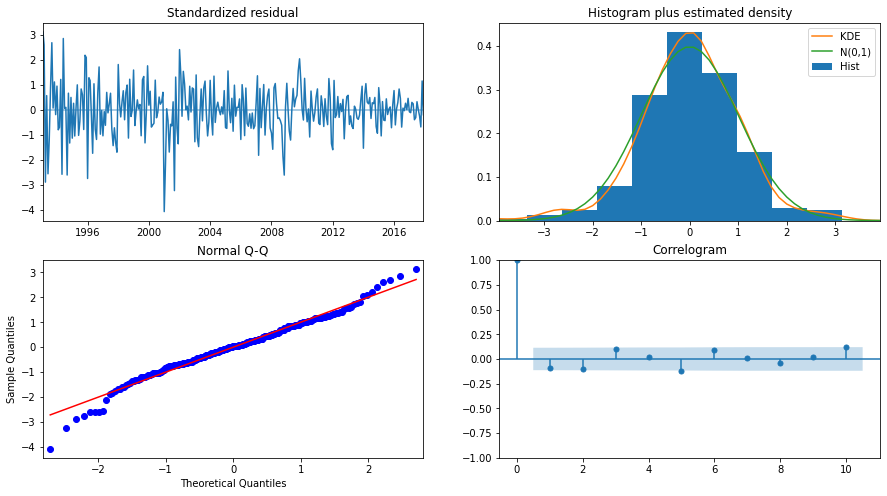

In [93]:
res.plot_diagnostics(figsize=(15,8))
plt.show()

We can see from the above plots that the model is good except some outliers


In [95]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  299
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 654.537
Date:                Sun, 10 Apr 2022   AIC                          -1297.075
Time:                        18:41:14   BIC                          -1274.872
Sample:                    02-01-1993   HQIC                         -1288.188
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.005      0.264      0.792      -0.009       0.012
ar.L1         -1.8187      0.063    -28.928      0.000      -1.942      -1.695
ar.L2         -0.8416      0.060    -14.095      0.0

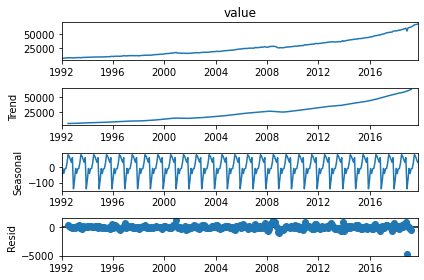

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(nonretail["value"],period=12)
decomp.plot()
plt.show()

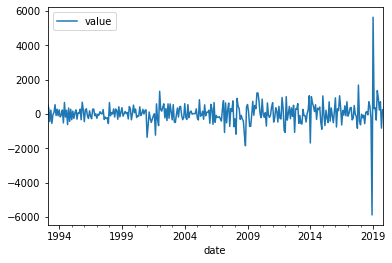

In [97]:
#Seasonal differencing and normal differencing
nonretail_diff = nonretail.diff(1).diff(12).dropna()
nonretail_diff.plot()
plt.show()

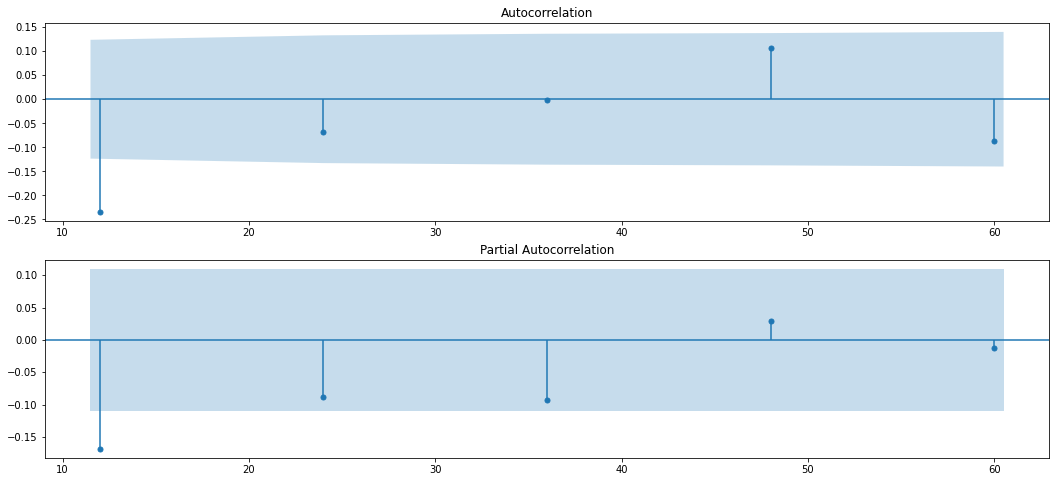

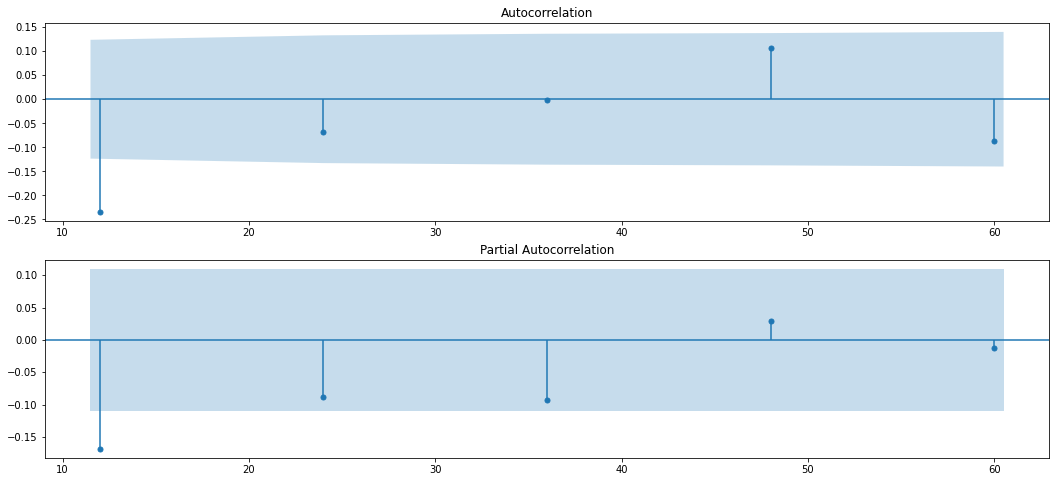

In [99]:
#Seasonal ACF and PACF
lags = [12, 24, 36, 48, 60]
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(18,8))
plot_acf(nonretail_diff,lags=lags,zero=False,ax=ax1)
plot_pacf(nonretail_diff,lags=lags,zero=False,ax=ax2)

We can see from seasonal ACF anf PACF plots that there is no seasonal orders significant


In [100]:
#SARIMAX
train_full = nonretail.loc[:"2016"]
test_full = nonretail.loc["2017":]

sarima_mod = SARIMAX(train_full,order=(2,1,3),seasonal_order=(0,1,0,12))
sarima_res = sarima_mod.fit(maxiter=500)
print(sarima_res.summary())

C:\Users\rishp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\rishp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  300
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 12)   Log Likelihood               -2158.048
Date:                             Sun, 10 Apr 2022   AIC                           4328.095
Time:                                     18:43:44   BIC                           4350.052
Sample:                                 01-01-1992   HQIC                          4336.895
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7574      0.040     19.108      0.000       0.680       0.835
ar.L2         -0.7667      

In [101]:
pip install pmdarima

  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
Note: you may need to restart the kernel to use updated packages.


In [102]:
import pmdarima as pm
results = pm.auto_arima(nonretail,maxiter=500,seasonal=True,m=12,information_criterion="aic",trace=True,error_action="ignore")
print(results.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=5081.098, Time=2.07 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=5466.445, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=5278.689, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=5143.258, Time=0.47 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=5083.021, Time=1.26 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=5084.239, Time=0.93 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=5083.096, Time=6.81 sec
 ARIMA(2,2,2)(1,0,2)[12]             : AIC=5083.096, Time=9.33 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=5087.215, Time=0.34 sec
 ARIMA(2,2,2)(0,0,2)[12]             : AIC=5083.141, Time=4.96 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=5084.666, Time=3.37 sec
 ARIMA(2,2,2)(2,0,2)[12]             : AIC=inf, Time=20.93 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=5079.507, Time=1.48 sec
 ARIMA(1,2,2)(0,0,1)[12]             : AIC=5081.488, Time=0.78 sec
 ARIMA(1,2,2)(1,0,0)[12

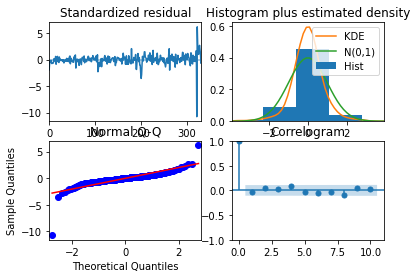

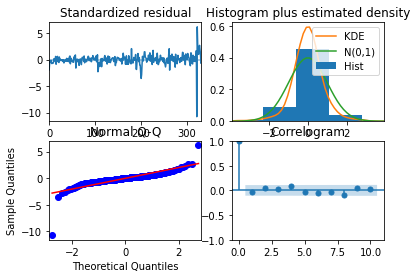

In [103]:
results.plot_diagnostics()


In [106]:
sarima_mod = SARIMAX(train_full,order=(0,2,2),seasonal_order=(1,0,1,12))
sarima_res = sarima_mod.fit(maxiter=500)
print(sarima_res.summary())

C:\Users\rishp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\rishp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  300
Model:             SARIMAX(0, 2, 2)x(1, 0, [1], 12)   Log Likelihood               -2149.147
Date:                              Sun, 10 Apr 2022   AIC                           4308.294
Time:                                      18:52:24   BIC                           4326.779
Sample:                                  01-01-1992   HQIC                          4315.693
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1638      0.033    -35.511      0.000      -1.228      -1.100
ma.L2          0.21

C:\Users\rishp\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


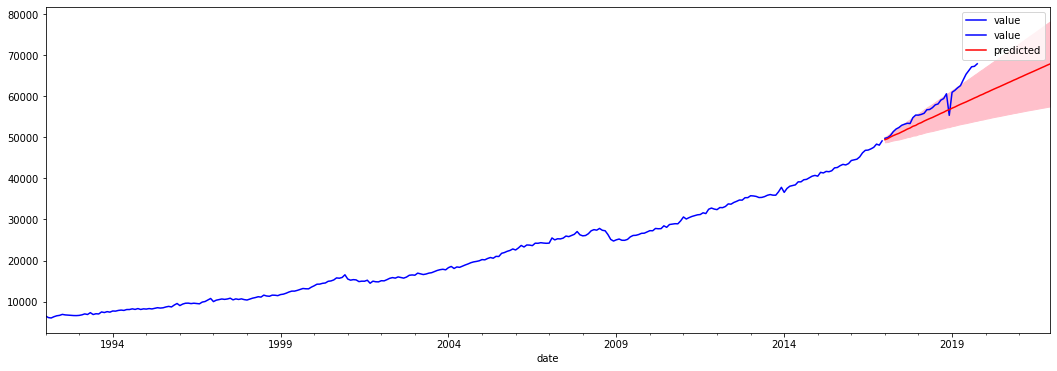

In [107]:
forecast = sarima_res.get_forecast(steps=60)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()
fig,ax = plt.subplots(figsize=(18,6))
train_full.plot(ax=ax,label="observed",color="blue")
test_full.plot(ax=ax,color="blue")
mean_forecast.plot(ax=ax,color="r",label="predicted")
ax.fill_between(conf_int.index,conf_int["lower value"],conf_int["upper value"],color="pink")
ax.legend()
fig.show()

In [108]:
print(mean_forecast.iloc[-1])
print(conf_int.iloc[-1])

67870.3714640918
lower value    57516.885384
upper value    78223.857544
Name: 2021-12-01 00:00:00, dtype: float64


Model forecasts that sales will be ~67 Billion USD in December 2021